In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
path = "/content/drive/MyDrive/Colab Notebooks/NNFL_research_paper/"

x_train = pickle.load(open(path +"x_train.pickle","rb"))
y_train = pickle.load(open(path +"y_train.pickle","rb"))

In [ ]:
IMG_SIZE = 45

# normalizing the images (scaled to [0,1])
x_train = x_train/255

# reshaping the images to be used by sequential model
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(x_train.shape)

(128000, 45, 45, 3)


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.losses import MeanSquaredError
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
model = Sequential()

# first convolution layer with 32 filters, filter size = 6*6, MaxPool layer 2*2
model.add(Conv2D(32, (6,6), activation='relu', input_shape=(45,45,3)))
model.add(MaxPool2D(2,2))
# second convolution layer with 64 filters, filter size = 5*5, MaxPool layer 2*2
model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPool2D(2,2))
# third convolution layer with 128 filters, filter size = 3*3
model.add(Conv2D(128, (3,3), activation='relu'))
# fourth convolution layer with 128 filters, filter size = 3*3, MaxPool layer 2*2
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
# first dense + maxout layer of 2048 neurons
model.add(Dense(2048))
model.add(tfa.layers.Maxout(2048))
# second dense + maxout layer of 2048 neurons
model.add(Dense(2048))
model.add(tfa.layers.Maxout(2048))
# final dense layer with 37 neurons followed by rectification and normalization
model.add(Dense(37, activation='relu')) 
model.add(tf.keras.layers.LayerNormalization())
# using the intial learning rate = 0.04 and momentum = 0.9 as mentioned in the research paper
# although the learning rate is decreased tenfold after 18 million examples 
# but we are keeping it constant as we are using only 128000 examples
opt = SGD(learning_rate=0.04, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss=MeanSquaredError(), metrics=['accuracy'])

In [ ]:
# out of 128000 examples we have kept out 2000 examples for testing
# we have shuffled the dataset before storing in the pickle file 
# therefore 100 choosen test images are completely random
x_test = x_train[126000:]
y_test = y_train[126000:]
x_train = x_train[:126000]
y_train = y_train[:126000]

In [ ]:
# we have taken number of epochs = 5 as training is taking too much time (session crashing after using all RAM) and also after 3-4 epochs training error is almost constant
history = model.fit(x_train,y_train, batch_size=16, epochs = 5)

Epoch 1/5
7875/7875 [==============================] - 1068s 136ms/step - loss: 0.0276 - accuracy: 0.5952
Epoch 2/5
7875/7875 [==============================] - 1086s 138ms/step - loss: 0.0268 - accuracy: 0.5985
Epoch 3/5
7875/7875 [==============================] - 1081s 137ms/step - loss: 0.0268 - accuracy: 0.5985
Epoch 4/5
7875/7875 [==============================] - 1074s 136ms/step - loss: 0.0268 - accuracy: 0.5985
Epoch 5/5
7875/7875 [==============================] - 1074s 136ms/step - loss: 0.0268 - accuracy: 0.5985


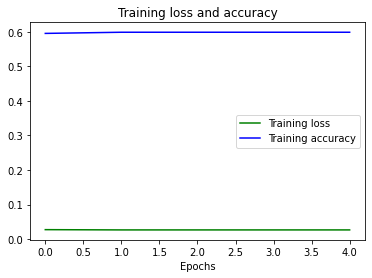

In [ ]:
# plotting training loss and accuracy across epochs
loss_train = history.history['loss']
acc_train = history.history['accuracy']
epochs = range(0,5)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, acc_train, 'b', label='Training accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
# To save the model and trained weights 

# serialize model to JSON
model_json = model.to_json()
with open(path+"model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(path+"model.h5")
print("Model saved")

Model saved


In [ ]:
# loading the saved model
json_file = open(path+'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path+"model.h5")
print("Model loaded")

Model loaded


In [ ]:
loaded_model.compile(loss=MeanSquaredError(), optimizer=SGD(), metrics=['accuracy'])
# testing the model on 100 examples out as mentioned in the instructions 
# x_test, y_test contains 2000 examples but we are only using 100 examples
score = loaded_model.evaluate(x_test[:100], y_test[:100], verbose=0)
print(score)
print("Testing error (RMSE) = ",score[0])
print("Testing accuracy = ",score[1]*100,"%")

[0.025881435722112656, 0.6600000262260437]
Testing error (RMSE) =  0.025881435722112656
Testing accuracy =  66.00000262260437 %
